<a href="https://colab.research.google.com/github/somayehch/L02-Image-Processing-Fundamentals/blob/main/L03_B_%F0%9D%91%BA%F0%9D%92%90%F0%9D%92%8E%F0%9D%92%82%F0%9D%92%9A%F0%9D%92%86%F0%9D%92%89_ITAI_1378.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run this only if imports fail later:
# !pip install -q numpy matplotlib tensorflow scikit-learn


In [2]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score


***load CIFAR-10***

This gives 50,000 train + 10,000 test color images (32x32x3) and labels.

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Train: (50000, 32, 32, 3) (50000, 1)
Test : (10000, 32, 32, 3) (10000, 1)


***choose classes + preprocessing***

We'll keep it light by using 3 classes (e.g., cat, dog, ship).

Then: grayscale → normalize → flatten.


***pick 3 classes and filter***

In [4]:
chosen_classes = ['cat','dog','ship']
class_indices = [class_names.index(c) for c in chosen_classes]

mask_train = np.isin(y_train, class_indices).flatten()
mask_test  = np.isin(y_test,  class_indices).flatten()

Xtr, ytr = X_train[mask_train], y_train[mask_train].ravel()
Xte, yte = X_test[mask_test],  y_test[mask_test].ravel()

print("Subset train:", Xtr.shape, ytr.shape)
print("Subset test :", Xte.shape, yte.shape)


Subset train: (15000, 32, 32, 3) (15000,)
Subset test : (3000, 32, 32, 3) (3000,)


***convert to grayscale***

**Why:** simpler features, faster training (one channel instead of three).

Formula: 0.2989*R + 0.5870*G + 0.1140*B

In [5]:
def rgb2gray(x):
    return np.dot(x[...,:3], [0.2989, 0.5870, 0.1140])

Xtr_gray = rgb2gray(Xtr).astype(np.float32)
Xte_gray = rgb2gray(Xte).astype(np.float32)
print(Xtr_gray.shape, Xtr_gray.min(), Xtr_gray.max())


(15000, 32, 32) 0.0 254.9745


***normalize to 0..1 and flatten***

**Why normalize:** models learn better when values are in a similar range.

**Why flatten:** SVM expects a 2D table: rows = images, columns = features.

In [6]:
Xtr_norm = Xtr_gray / 255.0
Xte_norm = Xte_gray / 255.0

Xtr_flat = Xtr_norm.reshape(Xtr_norm.shape[0], -1)  # N × 1024
Xte_flat = Xte_norm.reshape(Xte_norm.shape[0], -1)
Xtr_flat.shape, Xte_flat.shape


((15000, 1024), (3000, 1024))

***quick visual check***



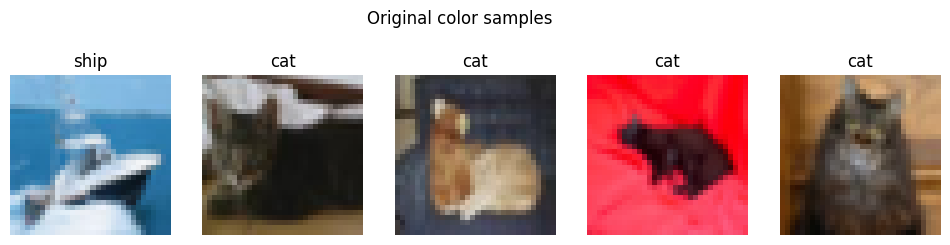

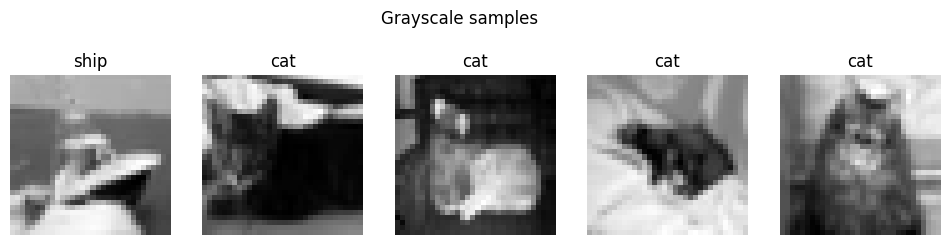

In [7]:
plt.figure(figsize=(12,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(Xtr[i])
    plt.title(class_names[ytr[i]])
    plt.axis('off')
plt.suptitle("Original color samples"); plt.show()

plt.figure(figsize=(12,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(Xtr_gray[i], cmap='gray')
    plt.title(class_names[ytr[i]])
    plt.axis('off')
plt.suptitle("Grayscale samples"); plt.show()


# **train the linear SVM**


***train and predict***

**What is SVM (super short):**

Draw a boundary (hyperplane) that best separates classes with a big margin.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import time

t0 = time.time()
pca = PCA(n_components=64, random_state=42)   # reduce 1024 → 64
Xtr_pca = pca.fit_transform(Xtr_flat)
Xte_pca = pca.transform(Xte_flat)

clf = LinearSVC(max_iter=5000, random_state=42)
clf.fit(Xtr_pca, ytr)
yp = clf.predict(Xte_pca)
t1 = time.time()

print(f"Accuracy (PCA-64 + LinearSVC): {accuracy_score(yte, yp):.3f}  |  Time: {t1 - t0:.1f}s")
print("\nReport:\n", classification_report(yte, yp, target_names=chosen_classes))


In [9]:
# ==== SUPER-FAST TRAINING CELL ====
# Uses: 1) small random subset (1500)  2) PCA(32)  3) LinearSVC
# Should finish in seconds on a normal laptop.

import numpy as np, gc, time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample

# 0) make sure features are float32 (saves RAM, speeds PCA)
Xtr_flat = Xtr_flat.astype(np.float32, copy=False)
Xte_flat = Xte_flat.astype(np.float32, copy=False)

# 1) take a smaller training sample (speed boost)
X_small, y_small = resample(Xtr_flat, ytr, n_samples=1500, random_state=42)

# 2) dimensionality reduction (1024 -> 32)
t0 = time.time()
pca = PCA(n_components=32, svd_solver='randomized', random_state=42)
Xtr_pca = pca.fit_transform(X_small)
Xte_pca = pca.transform(Xte_flat)

# 3) quick linear classifier
clf = LinearSVC(max_iter=3000, random_state=42)
clf.fit(Xtr_pca, y_small)
yp = clf.predict(Xte_pca)
t1 = time.time()

print(f"Time: {t1 - t0:.1f}s  |  Accuracy: {accuracy_score(yte, yp):.3f}")
print("\nReport:\n", classification_report(yte, yp, target_names=chosen_classes))

# 4) clean up a bit
del X_small, Xtr_pca, Xte_pca; gc.collect()


Time: 0.5s  |  Accuracy: 0.539

Report:
               precision    recall  f1-score   support

         cat       0.47      0.44      0.46      1000
         dog       0.51      0.41      0.46      1000
        ship       0.61      0.77      0.68      1000

    accuracy                           0.54      3000
   macro avg       0.53      0.54      0.53      3000
weighted avg       0.53      0.54      0.53      3000



19337



---



***NOTE:***

At the beginning, my linear SVM program didn't really work — it was too heavy and my laptop kept getting stuck. I didn't want to give up, so I tried a different approach with a smaller set of images and a faster method. That finally worked, and I was able to see results: ships were easier for the model to recognize, but cats and dogs were still tricky.challenging.remained tricky. challenging.


---



# **confusion matrix + saving a small artifact**

confusion matrix (to see where it's wrong)

In [10]:
from sklearn.metrics import confusion_matrix
import itertools
cm = confusion_matrix(yte, yp, labels=class_indices)

# reorder rows/cols into chosen_classes order
order = class_indices
cm = cm[np.ix_(order, order)]

plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(3), chosen_classes, rotation=45)
plt.yticks(range(3), chosen_classes)
for i, j in itertools.product(range(3), range(3)):
    plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout(); plt.show()


IndexError: index 3 is out of bounds for axis 0 with size 3

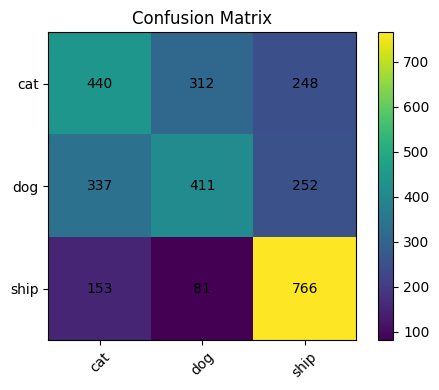

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

# Build confusion matrix in the order of your chosen classes
cm = confusion_matrix(yte, yp, labels=class_indices)  # <-- labels fixes the order

# Plot
plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(len(chosen_classes)), chosen_classes, rotation=45)
plt.yticks(range(len(chosen_classes)), chosen_classes)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()




---

**NOTE:**

At first, my confusion matrix didn't work because I tried to use the original CIFAR-10 class numbers (like 3, 5, 8), but my matrix only had 3 rows and columns. That made Python show an “index out of bounds” error. I fixed it by giving the labels argument directly in confusion_matrix, so it built the matrix in the right order for my classes (cat, dog, ship). Now the rows and columns match my class names without any extra steps.



---




save a tiny metrics file (nice for GitHub)

In [12]:
import json, os
os.makedirs("artifacts", exist_ok=True)
with open("artifacts/metrics.json", "w") as f:
    json.dump({
        "chosen_classes": chosen_classes,
        "test_accuracy_linear_svm": float(accuracy_score(yte, yp))
    }, f, indent=2)
print("Saved artifacts/metrics.json")


Saved artifacts/metrics.json
